In [52]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [158]:
S1o= 100        #Intial Value for stock 1
S2o= 100        #Intial Value for stock 2
S3o= 100        #Intial Value for stock 3
K=100           #Strike 
r = 0.05        #Risk free rate
T = 1           #time
sig = 0.3       #Volatility 
rho = 0.2       #Cross Correlation 
div = 0.02      #Dividends
N =10000    #Simulations 

In [182]:
#Part a

#Generate Normal Random Variables using Cholsky decomposition
z1 = np.random.normal(0,1,N)
z2 = z1*rho + (1 - rho**2)**0.5 * np.random.normal(0,1,N)
z3 = rho*z1 + (1 - rho**2)**-0.5 *(rho - rho**2)*z2 + ((1 - rho**2 - ((rho - rho**2)**2)/(1-rho**2))**0.5)*np.random.normal(0,1,N)

#Generate Stock prices and calculate Payoff 
S1 = S1o * np.exp((r - div - (sig**2)/2)*T + sig * z1)
S2 = S2o * np.exp((r - div - (sig**2)/2)*T + sig * z2)
S3 = S3o * np.exp((r - div - (sig**2)/2)*T + sig * z3)

Payoff = [max(S1[i] +S2[i] - S3[i] - K,0) for i in range(0,N)]

print('Price of European Basket Option =', np.mean(Payoff))
print('Variance of price of European Basket Option =', np.var(Payoff))

Price of European Basket Option = 21.566500606109955
Variance of price of European Basket Option = 1089.8558914035555


In [234]:
m = 12 # No of Discretisation Steps

#intialize Stock prices 
St1 = [[S1o]*N]
St2 = [[S2o]*N]
St3 = [[S3o]*N]
Payoff = [[0]*N]

#Debug variables
Z1_Debug = []
Z2_Debug = []
Z3_Debug = []
Cont_Val_Debug = []

# loop through all time steps to generate stock prices 
for i in range(1,m+1):
    #Generate correlated normal r.v.
    z1 = np.random.normal(0,1,N)
    z2 = z1*rho + (1 - rho**2)**0.5 * np.random.normal(0,1,N)
    z3 = rho*z1 + (1 - rho**2)**-0.5 *(rho - rho**2)*z2 + ((1 - rho**2 - ((rho - rho**2)**2)/(1-rho**2))**0.5)*np.random.normal(0,1,N)

    Z1_Debug.append(z1)
    Z2_Debug.append(z2)
    Z3_Debug.append(z3)

    # Generate Stock prices 
    St1.append(St1[0] * np.exp((r - div - sig**2/2)*(i*T/m) + sig * z1))
    St2.append(St2[0] * np.exp((r - div - sig**2/2)*(i*T/m) + sig * z2))
    St3.append(St3[0] * np.exp((r - div - sig**2/2)*(i*T/m) + sig * z3))

    #Generate Option Prices
    Payoff.append(list([max(St1[i][k] +St2[i][k] - St3[i][k] - K,0) for k in range(0,N)]))


#initialize Beta
no_of_basis_func = 6
beta = []

# Set basis function of Stock prices 
Bas1 = [[s**2 for s in t] for t in St1]
Bas2 = [[s**2 for s in t] for t in St2]
Bas3 = [[s**2 for s in t] for t in St3]
Bas4 = St1
Bas5 = St2
Bas6 = St3

#payoff function at each time
ht =np.reshape( [ max(St1[i][j] + St2[i][j] - St3[i][j] - K,0) for i in range(0,m+1) for j in range(0,N)] , (m+1,N))
Vt = [ht[m]]

for i in range(m,0,-1):
    #Run regression on payoff and basis functions with lag 1 to get Beta values
    X = pd.DataFrame(list(zip(Bas1[i],Bas2[i],Bas3[i],Bas4[i],Bas5[i],Bas6[i])))
    Y = np.reshape(Vt[m-i],(N,1))
    model = sm.OLS(Y,X).fit()
    
    #beta indexes are reversed here
    beta.append(list(model.params))

    #approximation of continuation value ; index will be reversed ; dimension is number of simulations 
    Cont_value = [np.exp(-r*T/m)*np.dot(beta[m-i],[Bas1[i][k],Bas2[i][k],Bas3[i][k],Bas4[i][k],Bas5[i][k],Bas6[i][k]]) for k in range(0,N)]

    #Debug
    Cont_Val_Debug.append(Cont_value)
    Cont_Val_Debug.append(Vt[m-i])

    #Assign the max of approx continuation value and payoff at that time
    temp = [max(Cont_value[k],ht[i][k]) for k in range(0,N)]
    #Assign the max of actual value and payoff at that time
    # temp = [max((np.exp(-r*T/m)*Vt[m-i][k]),ht[i][k]) for k in range(0,N)]

    # print(temp)
    Vt.append(temp)

# print(Vt)
#TODO


In [228]:
print(np.mean(Vt[12]))
print(np.var(Vt[12]))

77.03847497058932
184.62242490716415


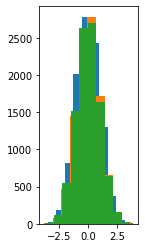

In [229]:
#Debug Code for Z values 
time = 11
plt.subplot(1,3,1)
plt.hist(Z1_Debug[time])
plt.hist(Z2_Debug[time])
plt.hist(Z3_Debug[time])
plt.show()


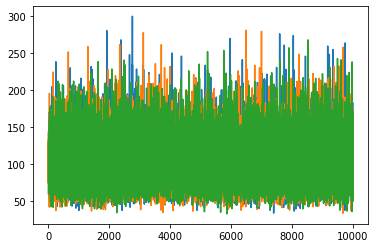

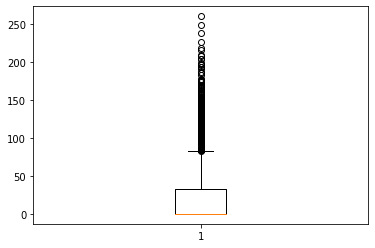

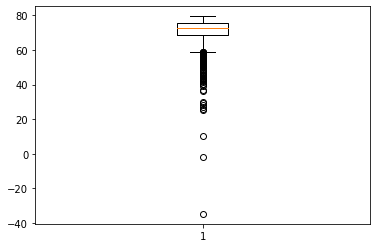

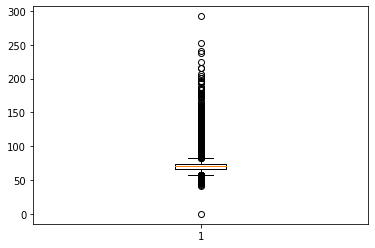

In [236]:
#debug code for stock prices 
# print(St1[time])
# print(St2[time])
# print(St3[time])
# print(Payoff[time])
time = 10
plt.plot(St1[time])
plt.plot(St2[time])
plt.plot(St3[time])
plt.show()
plt.boxplot(Payoff[time])
plt.show()
plt.boxplot(Cont_Val_Debug[time*2])
plt.show()
plt.boxplot(Cont_Val_Debug[time*2+1])
plt.show()

In [ ]:
#PLot Vt and cont vlue together to see regression values correctly